# Introduction to Python coroutines
There is much more to yield!  
  
Noam Elfanbaum  
[thespoon](http://thespoon.ghost.io)  
[@noamelf](https://twitter.com/noamelf)  

##Introduction

* In 1963 Melvine Conway (not the same guy from the Game of Life) came out with a paradaigm that will allow him to decouple COBOL programs into seperate units ([Design of a Separable Transition-Diagram Compiler](http://www.citemaster.net/get/ab3afb46-1d2a-11e4-ac35-00163e009cc7/p396-conway.pdf)). Instead of a routine that pass control to a subroutine and then gets it back, you have co-routines that passes control simultanoiusly from one another.
> Subroutines are special cases of... coroutines. – [Donald Knuth](http://en.wikipedia.org/wiki/Coroutine#cite_note-KnuthVol1_1_4_2-3)

* Coroutines paradigm was introduced to Python 2.5 in [PEP 342](http://legacy.python.org/dev/peps/pep-0342/) with the motivation of expanding the language expressivness as Guido and Phillip write in the PEP motivation section:
> Coroutines are a natural way of expressing many algorithms, such as simulations, games, asynchronous I/O, and other forms of event- driven programming or co-operative multitasking.

*The followings regards coroutine implementation in python 3.

## Basics
Each componenet is one of the building blocks of the one underneath:
* Iterators
* Generators
* Coroutines

### Iterators
Iterator objects represents a sequence of data. The iterator specification (protocol) includes 2 methods each iterator object must implement:
* `__iter__` - return the object itself.
* `__next__` - returns the next object in the sequence, raises `StopIteration` if empty.

In [17]:
# A class implementing the iterator protocol
class iter_range(object):
    def __init__(self, n):
        self.i = 0
        self.n = n

    def __iter__(self):
        return self

    def  __next__ (self):
        if self.i < self.n:
            i = self.i
            self.i += 1
            return i
        else:
            raise StopIteration()

In [43]:
it = iter_range(3)
for i in it:
    print(i, end=' ')

0 1 2 

### Generators
Generators helps us generate iterators easily. A generator is essentially a functions that contains a `yield` statement in it's body. 

In [19]:
def gen_range(n):
    i = 0
    while i < n:
        yield i
        i += 1

In [37]:
it = gen_range(3)
for i in it:
    print(i, end=' ')

0 1 2 

### Coroutines
Coroutines are very similar to generators but they utilize the yield statement to consume values.

In [21]:
# Example from David Beasely - http://www.dabeaz.com/coroutines/index.html

def grep(pattern):
 print('Looking for {}'.format(pattern))
 while True:
     line = yield
     if pattern in line:
         print(line)

In [23]:
g = grep('python')
next(g)

Looking for python


In [24]:
g.send('Yeah, but no, but yeah, but no')
g.send('A series of tubes')
g.send("python coroutines rock!")

python generators rock!


#### Coroutine initialization
A coroutine decorater to remove the need for calling `next` each time.

In [28]:
def coroutine(func):
    def start(*args,**kwargs):
        cr = func(*args,**kwargs)
        next(cr)
        return cr
    return start

#### `close` and `throw`
* When `close` is called a coroutine, a `GeneratorExit` exception is thrown, and the coroutine will end (the fact the exception is caught doesn't matter, the coroutine will exit anyhow).
* Same goes for `throw`, just that you can decide which exeption will be thrown and you can return a value (see examples).

In [90]:
# close() example
@coroutine
def add_up():
    s = 0
    try:
        while True:
            x = yield
            print(x, end=' ')
            s += x
    except GeneratorExit:
        print('\nThe sum is {}. Cleaning up.'.format(s))

In [95]:
adder_gen = add_up()
for i in range(5):
    adder_gen.send(i)
adder_gen.close()

0 1 2 3 4 
The sum is 10. Cleaning up.


In [91]:
# throw() example
@coroutine
def throw_me_an_exception():
    try:
        while True:
            x = yield
    except InterruptedError as e:
        print(e)
        yield 'got it' 

In [94]:
thrower_gen = throw_me_an_exception()
answer = thrower_gen.throw(InterruptedError, 'stop it')
print(answer)

next(adder)

stop it
got it


StopIteration: 

#### Objects vs Coroutines
It seems that there is a great similarity between regular objects and coroutines: they both has data members that can hold states. Then why use coroutines? Let's implement grep with a class and a coroutine:

In [122]:
# Benchmark authored by David Beasely - http://www.dabeaz.com/coroutines/index.html

class GrepHandler(object):
    def __init__(self, pattern, target):
        self.pattern = pattern
        self.target = target

    def send(self, line):
        if self.pattern in line:
            self.target.send(line)


@coroutine
def grep(pattern, target):
    while True:
        line = yield
        if pattern in line:
            target.send(line)


# A null-sink to send data
@coroutine
def null():
    while True: item = yield
   
line = 'python is nice'
p1 = grep('python', null())  # Coroutine
p2 = GrepHandler('python', null())  # Object

%timeit -n 1000 p1.send(line)
%timeit -n 1000 p2.send(line)

1000 loops, best of 3: 416 ns per loop
1000 loops, best of 3: 446 ns per loop


**So we got:**
* Elegance (agruable). 
* Speed.
* Job security (only you understand the code :) )

## Use cases
As [PEP 342](http://legacy.python.org/dev/peps/pep-0342/) mentions and Knuth & Ruskey decribes thouroughly in [Deconstructing Coroutines](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=98EAC35E08B1DB945E499F455F6EAD1E?doi=10.1.1.19.79&rep=rep1&type=pdf), coroutines can supply an elegant solution to a varaity of problems. We will start with a simple data pipes solutions and reach all the way to a mini OS.

### Use case 1 - Pipes
Pipes allows us to proccess large amounts of data without worrying about memory footprint and following unexpected crushes. Also, since we each chunk of data finishes the cycle as it is read, even if some mischief happens, the proccess does not need restart from the top. 

Regulary we will use generators to implement pipes but coroutines can offer us greater flexibilty and decopouling (and with asyncio also concurency, but this is for another talk).

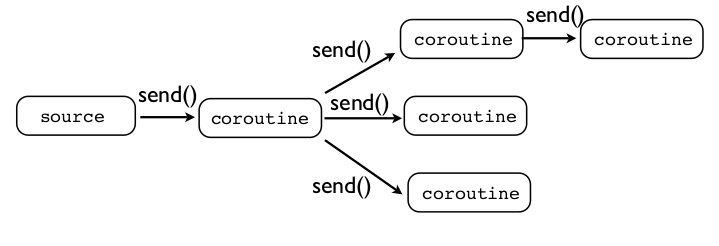

In [103]:
from IPython.display import Image,display_png
display_png(Image('branchy.png'))

### Pipe example
In this example, we need fetch data from furniture.com. As with any pipe we can abstract the steps taken to 3:
1. **Producer** - API request to furniture.com.
2. **Filter** - filtering and formating the data to match our needs.
3. **Sink** - Update our DB and indexer. 